In [1]:
from Bio import pairwise2
from Bio.Seq import Seq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns 
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.cluster.hierarchy as shc
import collections

/Users/DBurke/anaconda3/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
species = "horse"
bed_file = 'horse/'+'sep1_244_sorted.bed' # contains loci for all sep1 coordinates
results_file = 'horse/'+'v2output_sep1.txt'# contains VCF info for every sample that has SV in one of the identified coordinates

In [3]:
cons_seq = Seq("nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnTTTTTTTTTTTTTTTTTTAAAGATTTTATT \
    TTTTCCTTTTTCTCCCCAAAGCCCCnnnnCCGGTACnnnnnnnATAGTTGTGTATTCTTC \
    GTTGTnnnnGGGTTCTTCTAGTnTGTGGCATGTGGGACGCTnGCCTCAGCGTGGTCTGAT \
    GAGCAGTGCCATGTCCGCGCCCAGGATTnCGnnnAACCAACGAAACACTGGGCCGCCTGC \
    AGCGGAGCGCnnnnGnnCGAACTTAACCACTCGGCCACGGGGGCCAGCCCCnnnnnnnnn \
    nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn")
# Finding similarities
#score = pairwise2.align.globalxx(seq1, seq1, score_only = True)
#print(score)
print(len(cons_seq))
colors = {'PRZEWALSKI' : 'red', 'AKHAL-TEKE' : 'blue', 'ARABIAN' : 'green', \
          'QUARTER HORSE' : 'yellow', "MONGOLIAN" : "brown", "THOROUGHBRED" : 'orange', \
          'FRIESIAN' : 'black', 'HANOVARIAN' : 'pink', 'JEJU HORSE' : 'gray', \
          'CURLY HORSE' : 'purple', 'DEBAO' : 'teal', 'CRIOLLO' : 'tan'}

362


In [4]:
# get all loci
entries = []
with open(bed_file) as f:
    lines = f.readlines()
    for line in lines: #
        line = line.split()
        end = int(line[1]) + int(line[2])
        t = ">"+line[0]+":"+line[1]+"-"+str(line[1])
        if line[0] not in ['X','Y']:
            entries.append(t)
meta_data = pd.read_csv('horse/horse_sra_simple.csv')
meta_data.columns = ['sra','breed']
color_col = []
for index, row in meta_data.iterrows():
    row['breed'] = row['breed'] + str(random.randint(0,9))

In [5]:
samples = {}
with open(results_file) as f:
    lines = f.readlines()
    for line in lines:
        if "output" in line:
            sample_name = line.split('/')[1].strip()
            breed_name = meta_data.loc[meta_data['sra'] == sample_name]
            #print(breed_name, sample_name)
            breed_name = breed_name['breed'].values[0]
            samples[breed_name] = np.zeros(len(entries)) 
            
        else:
            t = line.split()
            chrom = t[0]
            start = t[1]
            end = start
            seq = re.search('SVINSSEQ=(.*);SPLIT_READS',line)
            seq = seq.group(1)
            s = ">"+chrom+":"+start+"-"+end
            if s in entries and chrom not in  ['X', 'Y']: # SV is in TE loci, get percent identify to cons seq
                idx = entries.index(s)
                score = pairwise2.align.globalxx(cons_seq, Seq(seq), score_only = True)
                samples[breed_name][idx] = score
print(len(samples.keys()))

36


In [6]:
df=pd.DataFrame.from_dict(samples,orient='index').transpose()
#df = df.loc[:, ~df.columns.str.startswith('QUARTER')]
#df = df.loc[:, ~df.columns.str.startswith('FRIESIAN')]
#df = df.loc[:, ~df.columns.str.startswith('MONGOLIAN')]
#df = df.loc[:, ~df.columns.str.startswith('PRZ')]
#df = df.loc[:, ~df.columns.str.startswith('THOROUGH')]
#df = df.loc[:, ~df.columns.str.startswith('CRIOLLO')]
#df = df.loc[:, ~df.columns.str.startswith('DEBAO')]
#df = df.loc[:, ~df.columns.str.startswith('HANOV')]
#df = df.loc[:, ~df.columns.str.startswith('JEJU')]
#df = df.loc[:, ~df.columns.str.startswith('CURLY')]
#df = df.loc[:, ~df.columns.str.startswith('AKHAL')]
#df = df.loc[:, ~df.columns.str.startswith('ARAB')]

cols = list(df.columns.values)
cols = sorted(cols, key=str.lower)
df_new = df[cols]
df_final = df_new.iloc[0:900]
df_final = df_final.transpose()

In [7]:
print(df_final.head())

             0    1      2    3      4      5      6    7    8    9    ...  \
AKHAL-TEKE0  0.0  0.0    0.0  0.0  230.0    0.0  222.0  0.0  0.0  0.0  ...   
AKHAL-TEKE5  0.0  0.0    0.0  0.0  230.0  225.0    0.0  0.0  0.0  0.0  ...   
AKHAL-TEKE8  0.0  0.0  230.0  0.0    0.0    0.0  222.0  0.0  0.0  0.0  ...   
ARABIAN3     0.0  0.0  230.0  0.0    0.0    0.0  222.0  0.0  0.0  0.0  ...   
ARABIAN4     0.0  0.0    0.0  0.0    0.0    0.0  222.0  0.0  0.0  0.0  ...   

               801  802  803  804  805    806  807  808  809    810  
AKHAL-TEKE0    0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  
AKHAL-TEKE5    0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  
AKHAL-TEKE8  229.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  
ARABIAN3       0.0  0.0  0.0  0.0  0.0  220.0  0.0  0.0  0.0  226.0  
ARABIAN4     229.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  

[5 rows x 811 columns]


In [8]:
s_names = list(df_final.iloc[:,0].index)
breed_names = s_names
breed_names = [s[: -1] for s in s_names]
contents = {s:[] for s in breed_names}
print(contents)
# get matrix for each breed
i = 0
for idx,row in df_final.iterrows():
    new_entry = {}
    new_entry[idx] = list(row.values)
    contents[idx[:-1]].append(new_entry)

{'AKHAL-TEKE': [], 'ARABIAN': [], 'CRIOLLO': [], 'CURLY HORSE': [], 'DEBAO': [], 'FRIESIAN': [], 'HANOVARIAN': [], 'JEJU HORSE': [], 'MONGOLIAN': [], 'PRZEWALSKI': [], 'QUARTER HORSE': [], 'THOROUGHBRED': []}


In [9]:
# get min and max of each column for each breed 
breed_devs = {s:[] for s in breed_names}
for breed in contents.keys():
    breed_matrix = []
    for i in range(len(contents[breed])):
        sample = list(contents[breed][i].keys())[0]
        breed_matrix.append(contents[breed][i][sample])
    breed_matrix = np.array(breed_matrix)
    df = pd.DataFrame(breed_matrix)
    minvals = df[df>0.01].min(axis=0).values
    maxvals = df.max(axis=0).values
    breed_devs[breed] = (minvals, maxvals)

In [10]:
s_names = list(df_final.iloc[:,0].index)
breed_names = s_names
breed_names = [s[: -1] for s in s_names]
breed_count = collections.Counter(breed_names)
contents = []
i = 0 
for i in range(len(df_final.columns)):
    vals = np.array(df_final.iloc[:,i].values)
    idx = np.where(vals!=0)[0]
    pos_hits = [s_names[n][:-1] for n in idx]
    
    c = collections.Counter(pos_hits)
    #contents.append({k: v / sum(c.values()) for k, v in c.items()})
    #contents.append({k: (v/breed_count[k])/len(c.items()) for k, v in c.items()})
    contents.append({k: v for k, v in c.items()})

In [11]:
content5 = [contents[i]['THOROUGHBRED'] for i in range(0,len(minvals)) if 'THOROUGHBRED' in contents[i].keys()]

In [89]:
x = range(0,len(minvals))
minvals1 = breed_devs['ARABIAN'][0]
maxvals1 = breed_devs['ARABIAN'][1]
content1 = [contents[i]['ARABIAN']/10  if 'ARABIAN' in contents[i].keys() else 1 for i in range(0,len(minvals))]
minvals2 = breed_devs['AKHAL-TEKE'][0]
maxvals2 = breed_devs['AKHAL-TEKE'][1]
content2 = [contents[i]['AKHAL-TEKE']/10  if 'AKHAL-TEKE' in contents[i].keys() else 1 for i in range(0,len(minvals))]
minvals3 = breed_devs['MONGOLIAN'][0]
maxvals3 = breed_devs['MONGOLIAN'][1]
content3 = [contents[i]['MONGOLIAN']/10 if 'MONGOLIAN' in contents[i].keys() else 1 for i in range(0,len(minvals))]
minvals4 = breed_devs['PRZEWALSKI'][0]
maxvals4 = breed_devs['PRZEWALSKI'][1]
content4 = [contents[i]['PRZEWALSKI']/10 if 'PRZEWALSKI' in contents[i].keys() else 1 for i in range(0,len(minvals))]
minvals5 = breed_devs['THOROUGHBRED'][0]
maxvals5 = breed_devs['THOROUGHBRED'][1]
content5 = [contents[i]['THOROUGHBRED']/10  if 'THOROUGHBRED' in contents[i].keys() else 1 for i in range(0,len(minvals))]

#plt.xlim(0,100)

Text(0, 0.5, 'PID Score')

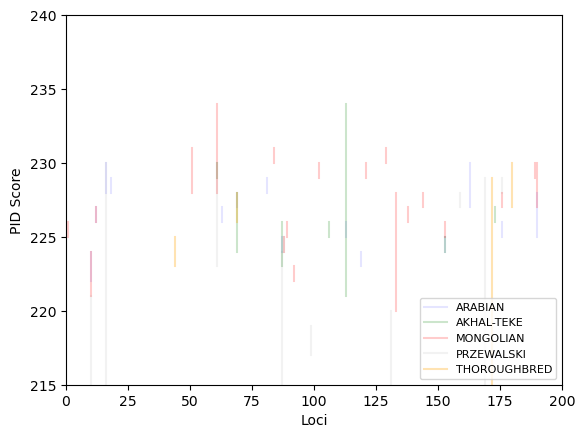

In [90]:
#plt.plot(range(0,len(minvals1)), [i for i in minvals1],  marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
#plt.plot(range(0,len(minvals1)), [i for i in maxvals1],  marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
blue = plt.plot((x,x), ([i for i in maxvals1],[j for j in minvals1]), c='blue', alpha = 0.1, label = 'ARABIAN')

#plt.plot(x, [k for k in minvals2],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
#plt.plot(x, [i for i in maxvals2],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
green = plt.plot((x,x), ([i for i in maxvals2],[j for j in minvals2]), c='green', alpha = 0.2, label = 'AKHAL-TEKE')

#plt.plot(x, [k for k in minvals3],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
#plt.plot(x, [i for i in maxvals3],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
red = plt.plot((x,x), ([i for i in maxvals3],[j for j in minvals3]), c='red', alpha = 0.2, label = 'MONGOLIAN')

#plt.plot(x, [k for k in minvals4],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
#plt.plot(x, [i for i in maxvals4],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
gray = plt.plot((x,x), ([i for i in maxvals4],[j for j in minvals4]), c='gray', alpha = 0.1, label = 'PRZEWALSKI')

#plt.plot(x, [k for k in minvals5],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = 1)
#plt.plot(x, [i for i in maxvals5],marker = '.', c='black', alpha = 0.4, linestyle = 'None', markersize = [i for i in content5])
orange = plt.plot((x,x), ([i for i in maxvals5],[j for j in minvals5]), c='orange', alpha = 0.3, label = 'THOROUGHBRED')

plt.plot();
plt.legend(handles=[blue[0], green[0], red[0], gray[0], orange[0]], loc = 'lower right', fontsize = 8 )
plt.ylim(215,240)
plt.xlim(0,200)
plt.xlabel('Loci')
plt.ylabel('PID Score')

Text(0, 0.5, 'PID Score')

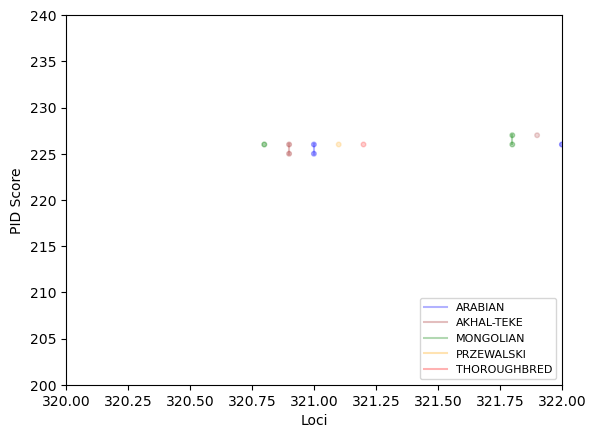

In [127]:
sz = 11
plt.scatter(x, minvals1, s=sz, alpha=content1, \
                  c='blue', label = 'ARABIAN')
plt.scatter(x, maxvals1, alpha = content1, \
                  c='blue', s = sz, label = 'ARABIAN')
blue = plt.plot((x,x), ([i for i in maxvals1],[j for j in minvals1]), c='blue', alpha = 0.3, label = 'ARABIAN')

pink_x =[y-0.1 for y in x]
#pink_x = x
plt.scatter(pink_x, minvals2, s=sz, alpha=content2, \
                  c='brown', label = 'AKHAL-TEKE')
plt.scatter(pink_x, maxvals2, alpha = content2, \
                  c='brown', s = sz, label = 'AKHAL-TEKE')
pink = plt.plot((pink_x,pink_x), ([i for i in maxvals2],[j for j in minvals2]), c='brown', alpha = 0.3, label = 'AKHAL-TEKE')

green_x = [y-0.2 for y in x]
#green_x = x
plt.scatter(green_x, minvals3, s = sz, alpha = content3, \
                  c='green', label = 'MONGOLIAN')
plt.scatter(green_x, maxvals3, alpha=content3, \
                  c='green', s = sz, label = 'MONGOLIAN')
green = plt.plot((green_x,green_x), ([i for i in maxvals3],[j for j in minvals3]), c='green', alpha = 0.3, label = 'MONGOLIAN')


orange_x = [y+0.1 for y in x]
#orange_x = x
plt.scatter(orange_x, minvals4, s = sz, alpha = content4, \
                  c='orange', label = 'PRZEWALSKI')
plt.scatter(orange_x, maxvals4, alpha=content4, \
                  c='orange', s = sz, label = 'PRZEWALSKI')
orange = plt.plot((orange_x,orange_x), ([i for i in maxvals4],[j for j in minvals4]), c='orange', alpha = 0.3, label = 'PRZEWALSKI')


red_x = [y+0.2 for y in x]
#red_x = x
plt.scatter(red_x, minvals5, s = sz, alpha=content5, \
                  c='red', label = 'THOROUGHBRED')
plt.scatter(red_x, maxvals5, s = sz, alpha=content5, \
                  c='red', label = 'THOROUGHBRED')
red = plt.plot((red_x,red_x), ([i for i in maxvals5],[j for j in minvals5]), c='red', alpha = 0.3, label = 'THOROUGHBRED')

plt.legend(handles=[blue[0],pink[0],green[0], orange[0], red[0]], loc = 'lower right', fontsize = 8 )
plt.ylim(200,240)
plt.xlim(320,322)
plt.xlabel('Loci')
plt.ylabel('PID Score')